# RNN

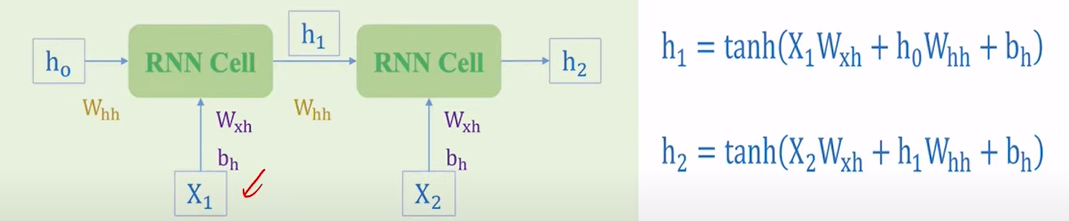




In [3]:
!pip install torchvision nltk pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [6]:
pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.6 MB/s eta 0:00:00


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from collections import Counter
from sklearn.model_selection import train_test_split


nltk.download("punkt")
nltk.download('punkt_tab')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = load_dataset("imdb")
train_texts, train_labels = dataset["train"]["text"], dataset["train"]["label"]
test_texts, test_labels = dataset["test"]["text"], dataset["test"]["label"]

def clean_text(text):
    text = text.lower()
    text = word_tokenize(text)
    return text

# Tokenize
train_tokenized = [clean_text(text) for text in train_texts]
test_tokenized = [clean_text(text) for text in test_texts]

word_counts = Counter(word for text in train_tokenized for word in text)
vocab = {word: i + 2 for i, (word, _) in enumerate(word_counts.most_common(20000))}
vocab["<PAD>"] = 0
vocab["<UNK>"] = 1

def text_to_sequence(text, vocab, max_length=200):
    seq = [vocab.get(word, vocab["<UNK>"]) for word in text]
    seq = seq[:max_length] + [vocab["<PAD>"]] * max(0, max_length - len(seq))
    return seq

train_sequences = [text_to_sequence(text, vocab) for text in train_tokenized]
test_sequences = [text_to_sequence(text, vocab) for text in test_tokenized]

class IMDBDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# DataLoader
BATCH_SIZE = 32
train_dataset = IMDBDataset(train_sequences, train_labels)
test_dataset = IMDBDataset(test_sequences, test_labels)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# RNN
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, num_layers=2):
        super(SentimentRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)  # (batch_size, seq_len, embed_dim)
        output, hidden = self.rnn(embedded)  # (batch, seq_len, hidden_dim)
        return self.fc(hidden[-1])

VOCAB_SIZE = len(vocab)
EMBED_DIM = 128
HIDDEN_DIM = 256
OUTPUT_DIM = 2

model = SentimentRNN(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Hàm train
def train(model, loader, optimizer, criterion, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(loader):.4f}")

# evaluate
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for texts, labels in loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f"Accuracy: {correct/total:.4f}")
train(model, train_loader, optimizer, criterion, num_epochs=5)
evaluate(model, test_loader)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Epoch 1/5, Loss: 0.7008
Epoch 2/5, Loss: 0.6982
Epoch 3/5, Loss: 0.7010
Epoch 4/5, Loss: 0.7036
Epoch 5/5, Loss: 0.7009
Accuracy: 0.4998
